## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt

transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [ ]:
import torch.nn as nn

reconstruction_loss_fn = nn.BCELoss(reduction='sum')

def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  reconstruction_loss = reconstruction_loss_fn(output, images)
  return reconstruction_loss, kl_loss


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=2*self.latent_feature)

    # decoder
    self.de_fc1 = nn.Linear(in_features=self.latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    std = 0.5*torch.exp(log_var)
    sample = torch.randn_like(std)*std + mu
    return sample

  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """

    # encoding
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = self.en_fc2(x)
    x = x.view(-1, 2, self.latent_feature)

    # Get mean and variance from the latent feature 
    mu = x[:, 0, :]
    log_var = x[:, 1, :]

    # Get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    x = F.relu(self.de_fc1(z))
    x = F.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)

    return x
  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)
    
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [ ]:
import torch.optim as optim

VAE = our_VAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=1e-3)

In [ ]:
def train(epoch, device):
  VAE.train()

  for batch_idx, (images, _) in enumerate(train_loader):
    optimizer.zero_grad()
    images = images.to(device)
    output, mu, log_var = VAE(images)
    reconstruction_loss, kl_loss = vae_loss(output, mu, log_var, images)
    loss = reconstruction_loss.item() + kl_loss.item()
    reconstruction_loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss/batch_size_train)
      reconstruction_losses.append(reconstruction_loss.item()/batch_size_train)
      kl_losses.append(kl_loss.item()/batch_size_train)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss/batch_size_train}')

def test(epoch, device):

  VAE.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = VAE(images)
      reconstruction_loss, kl_loss = vae_loss(output, mu, log_var, images)
      loss = reconstruction_loss.item() + kl_loss.item()      
      test_loss += loss
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [ ]:
train_losses = []
train_counter = []
reconstruction_losses = []
kl_losses = []
test_losses = []
test_counter = []
max_epoch = 20

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: [0/60000] Loss: 546.2041237354279
Epoch 1: [6400/60000] Loss: 215.8667755126953
Epoch 1: [12800/60000] Loss: 228.0478973388672
Epoch 1: [19200/60000] Loss: 226.37649536132812
Epoch 1: [25600/60000] Loss: 230.4947052001953
Epoch 1: [32000/60000] Loss: 229.71363067626953
Epoch 1: [38400/60000] Loss: 231.48776245117188
Epoch 1: [44800/60000] Loss: 237.32754516601562
Epoch 1: [51200/60000] Loss: 242.23641204833984
Epoch 1: [57600/60000] Loss: 241.5257339477539
Test result on epoch 1: Avg loss is 245.51042265625
Epoch 2: [0/60000] Loss: 238.2557373046875
Epoch 2: [6400/60000] Loss: 240.77903747558594
Epoch 2: [12800/60000] Loss: 245.71440887451172
Epoch 2: [19200/60000] Loss: 233.77159881591797
Epoch 2: [25600/60000] Loss: 241.439697265625
Epoch 2: [32000/60000] Loss: 246.09835052490234
Epoch 2: [38400/60000] Loss: 257.2385559082031
Epoch 2: [44800/60000] Loss: 257.9319610595703
Epoch 2: [51200/60000] Loss: 268.92928314208984
Epoch 2: [57600/60000] Loss: 270.99365234375
Test result

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


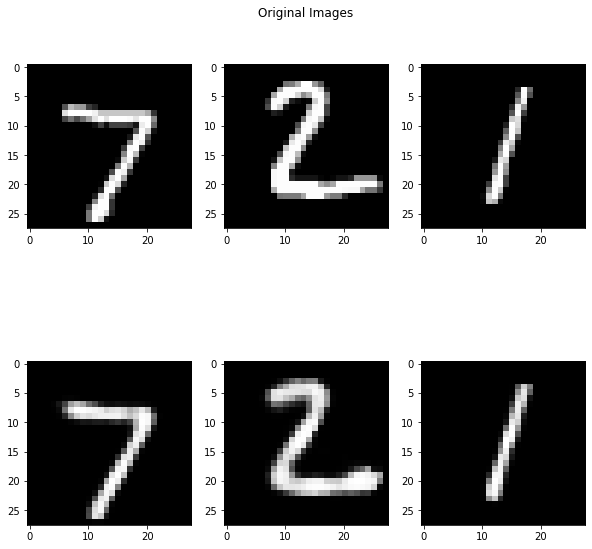

In [ ]:
batch_idx, (images, _) = next(enumerate(test_loader))
images = images.to(device)
output, mu, log_var = VAE(images)
output = output.cpu().detach()
images = images.cpu()

fig, axes = plt.subplots(2, 3, figsize = (10, 10))
grid = plt.GridSpec(3,1)
titles = ['Original Images', 'Reconstructed Images']

for i in range(2):
  row = fig.add_subplot(grid[i])
  row.set_title(titles[i])
  row.set_axis_off()

for idx in range(3):
  axes[0][idx].imshow(images[idx][0], cmap='gray')
  axes[1][idx].imshow(output[idx][0], cmap='gray')

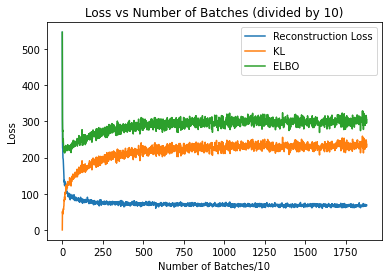

In [ ]:
import matplotlib.pyplot as plt

plt.plot(reconstruction_losses)
plt.plot(kl_losses)
plt.plot(train_losses)
plt.xlabel('Number of Batches/10')
plt.ylabel('Loss')
plt.title('Loss vs Number of Batches (divided by 10)')
plt.legend(['Reconstruction Loss', 'KL', 'ELBO'])

### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [ ]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      print(type(z))
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

In [ ]:
import torch.optim as optim

VAE = our_VAE(2)
optimizer = optim.Adam(VAE.parameters(), lr=1e-3)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


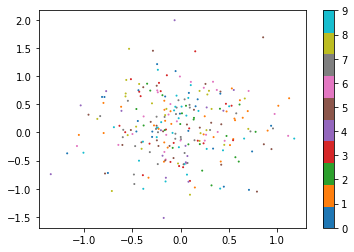

In [ ]:
plot_latent(VAE, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: [0/60000] Loss: 547.2713521420956
Epoch 1: [6400/60000] Loss: 181.27629852294922
Epoch 1: [12800/60000] Loss: 182.44185829162598
Epoch 1: [19200/60000] Loss: 186.80368041992188
Epoch 1: [25600/60000] Loss: 176.0937099456787
Epoch 1: [32000/60000] Loss: 171.04946517944336
Epoch 1: [38400/60000] Loss: 173.2663812637329
Epoch 1: [44800/60000] Loss: 181.5305519104004
Epoch 1: [51200/60000] Loss: 167.2244691848755
Epoch 1: [57600/60000] Loss: 172.63916015625
Test result on epoch 1: Avg loss is 173.008553125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


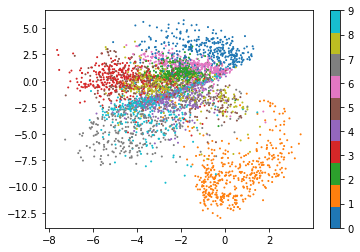

Epoch 2: [0/60000] Loss: 185.352707862854
Epoch 2: [6400/60000] Loss: 160.8431396484375
Epoch 2: [12800/60000] Loss: 175.15999031066895
Epoch 2: [19200/60000] Loss: 160.73830604553223
Epoch 2: [25600/60000] Loss: 177.03159141540527
Epoch 2: [32000/60000] Loss: 175.82773208618164
Epoch 2: [38400/60000] Loss: 168.22368621826172
Epoch 2: [44800/60000] Loss: 180.69991302490234
Epoch 2: [51200/60000] Loss: 174.45028018951416
Epoch 2: [57600/60000] Loss: 173.83490753173828
Test result on epoch 2: Avg loss is 171.4079501953125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


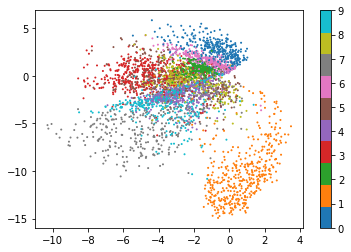

Epoch 3: [0/60000] Loss: 170.90635108947754
Epoch 3: [6400/60000] Loss: 166.66839599609375
Epoch 3: [12800/60000] Loss: 181.3416042327881
Epoch 3: [19200/60000] Loss: 175.38351821899414
Epoch 3: [25600/60000] Loss: 167.53840255737305
Epoch 3: [32000/60000] Loss: 172.9265899658203
Epoch 3: [38400/60000] Loss: 166.02045059204102
Epoch 3: [44800/60000] Loss: 179.14644050598145
Epoch 3: [51200/60000] Loss: 171.3259334564209
Epoch 3: [57600/60000] Loss: 167.6409454345703
Test result on epoch 3: Avg loss is 171.9534978515625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


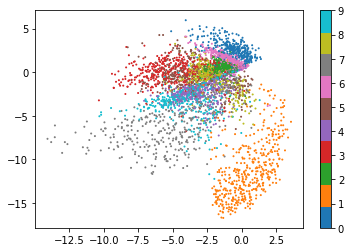

Epoch 4: [0/60000] Loss: 178.63900756835938
Epoch 4: [6400/60000] Loss: 166.47550773620605
Epoch 4: [12800/60000] Loss: 168.9807472229004
Epoch 4: [19200/60000] Loss: 166.01986503601074
Epoch 4: [25600/60000] Loss: 171.9098892211914
Epoch 4: [32000/60000] Loss: 165.77489280700684
Epoch 4: [38400/60000] Loss: 181.067045211792
Epoch 4: [44800/60000] Loss: 179.41020584106445
Epoch 4: [51200/60000] Loss: 170.79645919799805
Epoch 4: [57600/60000] Loss: 172.67045974731445
Test result on epoch 4: Avg loss is 173.69781953125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


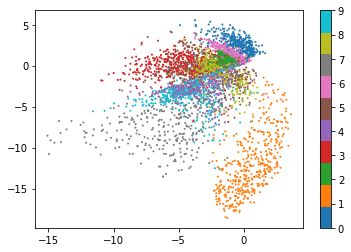

Epoch 5: [0/60000] Loss: 170.80756759643555
Epoch 5: [6400/60000] Loss: 165.3212127685547
Epoch 5: [12800/60000] Loss: 177.37778091430664
Epoch 5: [19200/60000] Loss: 168.12061882019043
Epoch 5: [25600/60000] Loss: 170.53963088989258
Epoch 5: [32000/60000] Loss: 175.8857879638672
Epoch 5: [38400/60000] Loss: 175.62676811218262
Epoch 5: [44800/60000] Loss: 177.25450897216797
Epoch 5: [51200/60000] Loss: 165.43156623840332
Epoch 5: [57600/60000] Loss: 176.44631385803223
Test result on epoch 5: Avg loss is 173.01103828125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


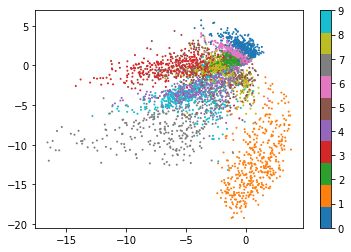

Epoch 6: [0/60000] Loss: 177.63170051574707
Epoch 6: [6400/60000] Loss: 176.05804252624512
Epoch 6: [12800/60000] Loss: 165.6398525238037
Epoch 6: [19200/60000] Loss: 175.81035614013672
Epoch 6: [25600/60000] Loss: 179.12273025512695
Epoch 6: [32000/60000] Loss: 180.50920486450195
Epoch 6: [38400/60000] Loss: 184.87688064575195
Epoch 6: [44800/60000] Loss: 181.0557632446289
Epoch 6: [51200/60000] Loss: 177.5350284576416
Epoch 6: [57600/60000] Loss: 173.37128257751465
Test result on epoch 6: Avg loss is 175.95065703125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


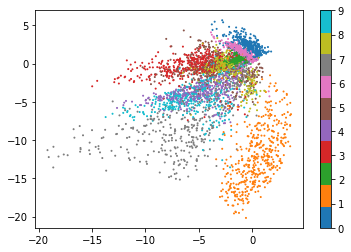

Epoch 7: [0/60000] Loss: 173.06254959106445
Epoch 7: [6400/60000] Loss: 173.48273468017578
Epoch 7: [12800/60000] Loss: 179.37302207946777
Epoch 7: [19200/60000] Loss: 167.9462890625
Epoch 7: [25600/60000] Loss: 171.79498100280762
Epoch 7: [32000/60000] Loss: 188.9505844116211
Epoch 7: [38400/60000] Loss: 184.43034744262695
Epoch 7: [44800/60000] Loss: 182.60603141784668
Epoch 7: [51200/60000] Loss: 174.53262901306152
Epoch 7: [57600/60000] Loss: 183.40018844604492
Test result on epoch 7: Avg loss is 177.0087326171875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


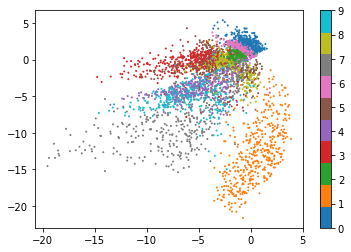

Epoch 8: [0/60000] Loss: 181.1753692626953
Epoch 8: [6400/60000] Loss: 177.70062255859375
Epoch 8: [12800/60000] Loss: 180.04023551940918
Epoch 8: [19200/60000] Loss: 182.8042449951172
Epoch 8: [25600/60000] Loss: 183.55051040649414
Epoch 8: [32000/60000] Loss: 185.37491989135742
Epoch 8: [38400/60000] Loss: 181.16930770874023
Epoch 8: [44800/60000] Loss: 177.57195281982422
Epoch 8: [51200/60000] Loss: 188.02092361450195
Epoch 8: [57600/60000] Loss: 175.3226261138916
Test result on epoch 8: Avg loss is 179.2746640625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


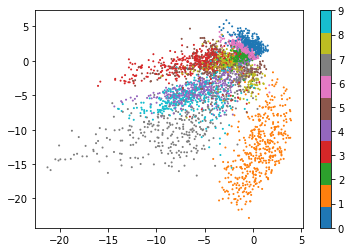

Epoch 9: [0/60000] Loss: 181.18362426757812
Epoch 9: [6400/60000] Loss: 174.42424392700195
Epoch 9: [12800/60000] Loss: 180.1050262451172
Epoch 9: [19200/60000] Loss: 172.24540901184082
Epoch 9: [25600/60000] Loss: 180.2080535888672
Epoch 9: [32000/60000] Loss: 190.37585067749023
Epoch 9: [38400/60000] Loss: 176.29005432128906
Epoch 9: [44800/60000] Loss: 187.62553787231445
Epoch 9: [51200/60000] Loss: 182.97802352905273
Epoch 9: [57600/60000] Loss: 177.47467803955078
Test result on epoch 9: Avg loss is 181.0515873046875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


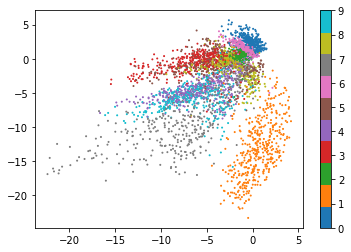

Epoch 10: [0/60000] Loss: 171.5193099975586
Epoch 10: [6400/60000] Loss: 184.00894927978516
Epoch 10: [12800/60000] Loss: 170.64858627319336
Epoch 10: [19200/60000] Loss: 171.3059844970703
Epoch 10: [25600/60000] Loss: 186.60898208618164
Epoch 10: [32000/60000] Loss: 185.52552032470703
Epoch 10: [38400/60000] Loss: 171.94869995117188
Epoch 10: [44800/60000] Loss: 186.4653549194336
Epoch 10: [51200/60000] Loss: 186.60400772094727
Epoch 10: [57600/60000] Loss: 185.45096588134766
Test result on epoch 10: Avg loss is 181.9481578125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


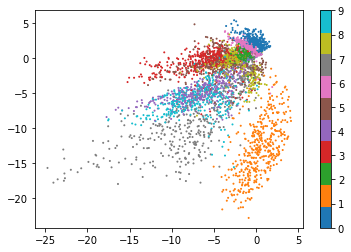

Epoch 11: [0/60000] Loss: 176.5721549987793
Epoch 11: [6400/60000] Loss: 184.6197738647461
Epoch 11: [12800/60000] Loss: 179.92181396484375
Epoch 11: [19200/60000] Loss: 187.2482681274414
Epoch 11: [25600/60000] Loss: 186.54341888427734
Epoch 11: [32000/60000] Loss: 190.35523986816406
Epoch 11: [38400/60000] Loss: 180.53697967529297
Epoch 11: [44800/60000] Loss: 176.13765716552734
Epoch 11: [51200/60000] Loss: 180.65595626831055
Epoch 11: [57600/60000] Loss: 195.1489143371582
Test result on epoch 11: Avg loss is 184.710713671875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


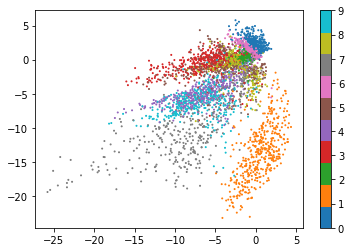

Epoch 12: [0/60000] Loss: 186.30571746826172
Epoch 12: [6400/60000] Loss: 189.10682678222656
Epoch 12: [12800/60000] Loss: 184.75457000732422
Epoch 12: [19200/60000] Loss: 179.63579559326172
Epoch 12: [25600/60000] Loss: 201.7611083984375
Epoch 12: [32000/60000] Loss: 191.64801025390625
Epoch 12: [38400/60000] Loss: 182.28546142578125
Epoch 12: [44800/60000] Loss: 184.1462173461914
Epoch 12: [51200/60000] Loss: 182.17822265625
Epoch 12: [57600/60000] Loss: 182.32422637939453
Test result on epoch 12: Avg loss is 185.592183984375
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


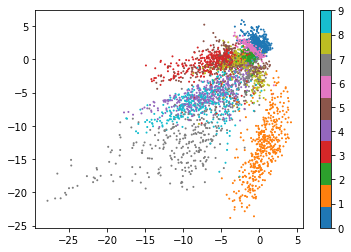

Epoch 13: [0/60000] Loss: 184.52230834960938
Epoch 13: [6400/60000] Loss: 171.5532112121582
Epoch 13: [12800/60000] Loss: 190.6856918334961
Epoch 13: [19200/60000] Loss: 189.57781600952148
Epoch 13: [25600/60000] Loss: 188.25336456298828
Epoch 13: [32000/60000] Loss: 179.63797760009766
Epoch 13: [38400/60000] Loss: 186.88799285888672
Epoch 13: [44800/60000] Loss: 194.02695846557617
Epoch 13: [51200/60000] Loss: 178.2289047241211
Epoch 13: [57600/60000] Loss: 183.55138397216797
Test result on epoch 13: Avg loss is 187.116923046875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


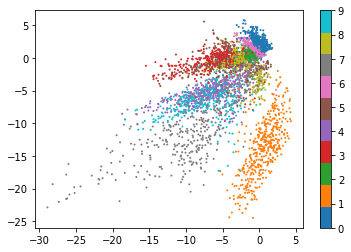

Epoch 14: [0/60000] Loss: 193.41736602783203
Epoch 14: [6400/60000] Loss: 209.17450714111328
Epoch 14: [12800/60000] Loss: 189.05431747436523
Epoch 14: [19200/60000] Loss: 185.88213348388672
Epoch 14: [25600/60000] Loss: 172.07085037231445
Epoch 14: [32000/60000] Loss: 186.38568878173828
Epoch 14: [38400/60000] Loss: 187.19491958618164
Epoch 14: [44800/60000] Loss: 183.31719970703125
Epoch 14: [51200/60000] Loss: 179.92373275756836
Epoch 14: [57600/60000] Loss: 187.17656707763672
Test result on epoch 14: Avg loss is 187.278981640625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


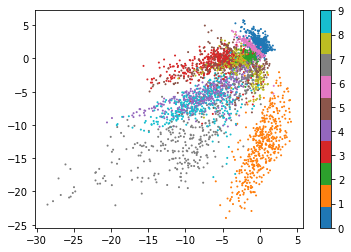

Epoch 15: [0/60000] Loss: 197.33463287353516
Epoch 15: [6400/60000] Loss: 180.38491439819336
Epoch 15: [12800/60000] Loss: 183.3294334411621
Epoch 15: [19200/60000] Loss: 184.67530822753906
Epoch 15: [25600/60000] Loss: 178.61248779296875
Epoch 15: [32000/60000] Loss: 190.10946655273438
Epoch 15: [38400/60000] Loss: 181.23916625976562
Epoch 15: [44800/60000] Loss: 217.85348892211914
Epoch 15: [51200/60000] Loss: 209.07333374023438
Epoch 15: [57600/60000] Loss: 197.31874084472656
Test result on epoch 15: Avg loss is 189.014563671875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


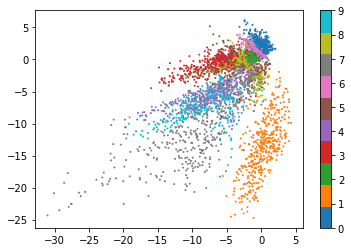

Epoch 16: [0/60000] Loss: 177.4346160888672
Epoch 16: [6400/60000] Loss: 197.26060104370117
Epoch 16: [12800/60000] Loss: 195.2804069519043
Epoch 16: [19200/60000] Loss: 191.6399383544922
Epoch 16: [25600/60000] Loss: 201.53166961669922
Epoch 16: [32000/60000] Loss: 181.9427261352539
Epoch 16: [38400/60000] Loss: 184.13920974731445
Epoch 16: [44800/60000] Loss: 182.19097137451172
Epoch 16: [51200/60000] Loss: 200.88806915283203
Epoch 16: [57600/60000] Loss: 196.35422897338867
Test result on epoch 16: Avg loss is 190.474516015625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


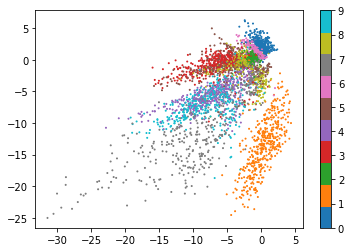

Epoch 17: [0/60000] Loss: 188.15465545654297
Epoch 17: [6400/60000] Loss: 180.7981414794922
Epoch 17: [12800/60000] Loss: 194.84022521972656
Epoch 17: [19200/60000] Loss: 178.0456771850586
Epoch 17: [25600/60000] Loss: 200.81868362426758
Epoch 17: [32000/60000] Loss: 190.060302734375
Epoch 17: [38400/60000] Loss: 208.1133270263672
Epoch 17: [44800/60000] Loss: 194.959228515625
Epoch 17: [51200/60000] Loss: 179.81908416748047
Epoch 17: [57600/60000] Loss: 182.5600929260254
Test result on epoch 17: Avg loss is 192.300026953125
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


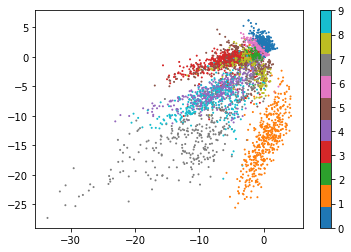

Epoch 18: [0/60000] Loss: 178.44962310791016
Epoch 18: [6400/60000] Loss: 184.5586166381836
Epoch 18: [12800/60000] Loss: 193.1199722290039
Epoch 18: [19200/60000] Loss: 189.51000595092773
Epoch 18: [25600/60000] Loss: 193.96492767333984
Epoch 18: [32000/60000] Loss: 197.219970703125
Epoch 18: [38400/60000] Loss: 202.1162452697754
Epoch 18: [44800/60000] Loss: 196.72418975830078
Epoch 18: [51200/60000] Loss: 193.33171844482422
Epoch 18: [57600/60000] Loss: 205.07740020751953
Test result on epoch 18: Avg loss is 193.76511796875
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


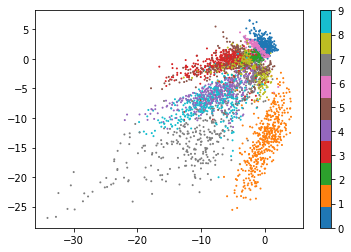

Epoch 19: [0/60000] Loss: 195.2249526977539
Epoch 19: [6400/60000] Loss: 194.121337890625
Epoch 19: [12800/60000] Loss: 179.9059295654297
Epoch 19: [19200/60000] Loss: 187.67745208740234
Epoch 19: [25600/60000] Loss: 197.06026458740234
Epoch 19: [32000/60000] Loss: 188.30377960205078
Epoch 19: [38400/60000] Loss: 185.31912994384766
Epoch 19: [44800/60000] Loss: 183.08336639404297
Epoch 19: [51200/60000] Loss: 191.39557647705078
Epoch 19: [57600/60000] Loss: 189.6564712524414
Test result on epoch 19: Avg loss is 193.42931640625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


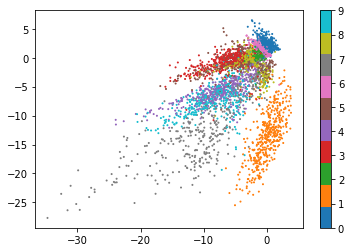

Epoch 20: [0/60000] Loss: 178.41837692260742
Epoch 20: [6400/60000] Loss: 183.61688613891602
Epoch 20: [12800/60000] Loss: 181.60882568359375
Epoch 20: [19200/60000] Loss: 184.81927871704102
Epoch 20: [25600/60000] Loss: 194.97987365722656
Epoch 20: [32000/60000] Loss: 201.99732208251953
Epoch 20: [38400/60000] Loss: 202.11148071289062
Epoch 20: [44800/60000] Loss: 179.12054824829102
Epoch 20: [51200/60000] Loss: 185.19614791870117
Epoch 20: [57600/60000] Loss: 194.4840316772461
Test result on epoch 20: Avg loss is 195.60784140625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


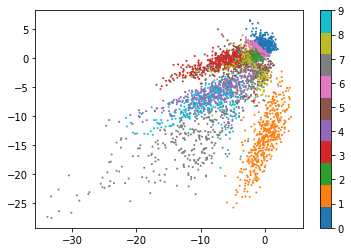

In [ ]:
train_losses = []
train_counter = []
reconstruction_losses = []
kl_losses = []
test_losses = []
test_counter = []
max_epoch = 20

for epoch in range(1, max_epoch+1):
  VAE.to(device)
  train(epoch, device=device)
  test(epoch, device=device)
  VAE.to('cpu')
  plot_latent(VAE, test_loader)

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

In [ ]:
zero_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
one_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)

indices_zero = train_dataset.targets == 0
zero_dataset.data, zero_dataset.targets = train_dataset.data[indices_zero], train_dataset.targets[indices_zero]

indices_one = train_dataset.targets == 1 
one_dataset.data, one_dataset.targets = train_dataset.data[indices_one], train_dataset.targets[indices_one]

batch_size_train, batch_size_test = 64, 1000

zero_loader = torch.utils.data.DataLoader(zero_dataset, batch_size=batch_size_train, shuffle=True)
one_loader = torch.utils.data.DataLoader(one_dataset, batch_size=batch_size_train, shuffle=False)

idx, (zero_images, _) = next(enumerate(zero_loader))
idx, (one_images, _) = next(enumerate(one_loader))


with torch.no_grad():
  _, _, z_0 = VAE.encoder(zero_images[0])
  _, _, z_1 = VAE.encoder(one_images[0])

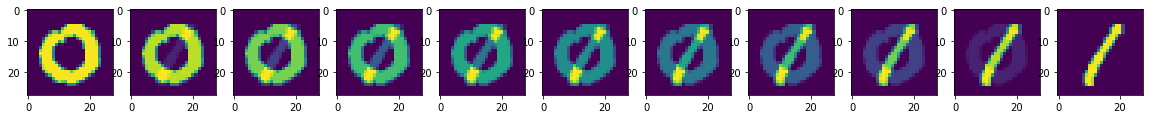

In [ ]:
fig, axes = plt.subplots(1, 11, figsize=(20, 20))

idx = 0;

for i in torch.linspace(0, 1.0, steps=11):
  x = i*one_images[0] + (1-i)*zero_images[0]
  axes[idx].imshow(x[0])
  idx = idx+1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


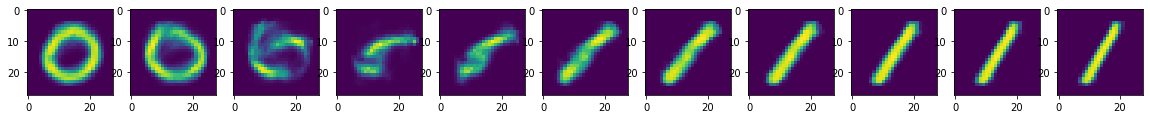

In [ ]:
fig, axes = plt.subplots(1, 11, figsize=(20, 20))

idx = 0;

for i in torch.linspace(0, 1.0, steps=11):
  z = i*z_1 + (1-i)*z_0
  x = VAE.decoder(z)
  x = x.to('cpu').detach()
  axes[idx].imshow(x[0][0])
  idx = idx+1